# Importy i pobranie danych

In [77]:
import pandas as pd
import math
import numpy as np
import requests
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from scipy import optimize

Poniższy kod jest przekopiowany z pliku Zad2c-3d

In [78]:
URL = "https://pl.wikipedia.org/wiki/Demografia_Polski"
resp = requests.get(URL) 
if resp.status_code == 200:    # czy stronę udało się otworzyć?
    soup = BeautifulSoup(resp.content,'html.parser')  # utowrzenie drzewa wyszukiwań
    tab = soup.find_all('table',{'class':"wikitable"})   # ekstrakcja tabel z drzewa wyszukiwań

for tag in soup.find_all(class_="reference"): # usuwanie wikipediowych referencji
    tag.decompose()

df = pd.read_html(str(tab[6]))[0]
df['Rok'] = df['Rok'].fillna(0).astype(int)
df.drop(df[df['Rok'] == 0].index, inplace=True)

df.set_index('Rok', inplace=True)

In [79]:
# formatowanie kolumny

df['Przyrostnaturalny'] = df['Przyrostnaturalny'].str.replace(" ", "") # usuń spacje z liczb
df['Przyrostnaturalny'] = df['Przyrostnaturalny'].str.replace("−", "-") # zastąp jeden rodzaj myślnika minusem
df['Przyrostnaturalny'] = df['Przyrostnaturalny'].str.replace("–", "-") # zastąp drugi rodzaj myślnika minusem
df['Przyrostnaturalny'] = df['Przyrostnaturalny'].astype(float)
df['Przyrostnaturalny'] = df['Przyrostnaturalny'] / 1000

In [80]:
bezrobocie = pd.read_html(str(tab[7]))[0]
bezrobocie.set_index('Rok', inplace=True)
bezrobocie = bezrobocie.astype(float)
bezrobocie = bezrobocie / 10

bezrobocie = bezrobocie.drop(labels=2021, axis=0)
bezrobocie = bezrobocie.drop(labels=2020, axis=0)

In [81]:
bezrobocie['Średnia'] = bezrobocie.mean(axis=1)
bezrobocie_srednia = bezrobocie['Średnia'].to_frame()


bezrobocie_srednia.insert(1, 'Przyrostnaturalny', df['Przyrostnaturalny'])
bezrobocie_srednia = bezrobocie_srednia.round(2)

display(bezrobocie_srednia)

,Średnia,Przyrostnaturalny
Rok,,
2019,5.43,-34.91
2018,6.07,-25.79
2017,7.27,-0.85
2016,8.94,-5.75
2015,10.48,-25.61
2014,12.32,-1.34
2013,13.53,-17.72
2012,12.80,1.46
2011,12.39,12.92


In [82]:
X = bezrobocie_srednia['Średnia'].values
display(X)

array([ 5.43,  6.07,  7.27,  8.94, 10.48, 12.32, 13.53, 12.8 , 12.39,
       12.11, 10.97,  9.82, 12.69, 16.15, 18.19, 19.51, 19.92])

In [83]:
Y = bezrobocie_srednia['Przyrostnaturalny'].values
display(Y)

array([-34.91, -25.79,  -0.85,  -5.75, -25.61,  -1.34, -17.72,   1.46,
        12.92,  34.8 ,  32.69,  35.1 ,  10.67,   4.54,  -3.88,  -7.37,
       -14.13])

# Wstęp do zadania 5D

W tym notatniku będę badał zależność przyrostu naturalnego od średniej rocznej stopy bezrobocia w latach 2003-2019. Aby zwiększyć czytelność wykresów dane przyrostu naturalnego przeskalowałem przez współczynnik 1/1000

**Błąd średniokwadratowy** <br>
Niech błąd przybliżenia dla pojedynczej $i$-tej pary pomiarów wynosi:
$$e_i=y_i-\overline{y_i}.$$

gdzie $$\overline{y_i}=ax_i + b$$

Miarą błędu niech będzie wyrażenie:

\begin{equation}
Q(v) = \frac{1}{N}\sqrt{\sum_{i=1}^Ne_i^2}\ 
\tag{3}
\end{equation}

gdzie $$v = \left[ \begin{array}{c} a \\ b \end{array} \right].$$

In [84]:
def lin(v, x):
  a,b = v
  return a*x + b

In [85]:
def Q(v):
  s = 0
  for i in range(0, len(X)):
    s = s + (Y[i] - lin(v, X[i]))**2
  return s**(1/2)/len(X)

Funkcją celu będzie funckja Q(v). Będę szukał minimum tej funkcji za pomocą optimize.fmin()

Przed rozpoczęciem eksperymentów zdefiniuję funkcję pokaz_2D, która będzie służyć do wyświetlania historii poszukiwań rozwiązania optymalnego dla każdego z przeprowadzonych eksperymentów

In [86]:
def pokaz_2D(Fcelu, x_historia, zakres):
  x_pocz, x_opt = x_historia[0], x_historia[-1]
  os_x1 = np.linspace(zakres[0], zakres[1], num=100)
  os_x2 = np.linspace(zakres[2], zakres[3], num=100)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
  macierz_Z = Fcelu([siatka_X1, siatka_X2])

  fig, ax = plt.subplots(figsize=(10,10))
  cplot = ax.contourf(siatka_X1, siatka_X2, macierz_Z, 10, cmap='Spectral_r', alpha=1)
  clines = ax.contour(siatka_X1, siatka_X2, macierz_Z, 10, colors='black')
  for punkt in x_historia:
      ax.plot(punkt[0], punkt[1], 'o', 
              color='white', markeredgecolor='black', markersize=5, alpha=0.7)
  ax.plot(x_pocz[0], x_pocz[1], 'd', 
          color='gray', markeredgecolor='black', markersize=10, alpha=0.7)    
  ax.plot(x_opt[0], x_opt[1], 'h', 
          color='white', markeredgecolor='black', markersize=15)
  ax.set_aspect('equal')
  ax.set_xlabel(r'$a$', fontsize=16)
  ax.set_ylabel(r'$b$', fontsize=16)
  ax.clabel(clines)
  fig.colorbar(cplot)
  return fig, ax

# Eksperyment 1

In [87]:
v_pocz_1 = np.random.normal(loc=5, scale=5, size=2)

x_opt_1, x_historia_1 = optimize.fmin(Q, v_pocz_1,disp=False, retall=True)

Punkt startowy v = [-3.16993795  7.41250737]
Współczynnik kierunkowy a = 0.5128529614347652
Współczynnik b = -6.596807140072545


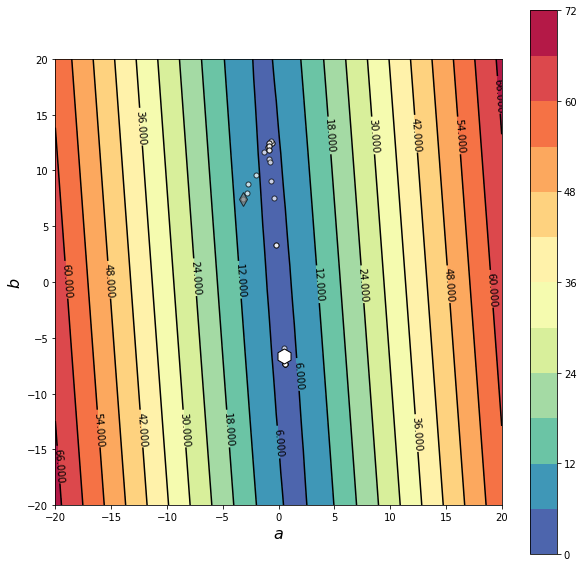

In [88]:
zakres=[-20, 20, -20, 20]
pokaz_2D(Q, x_historia_1, zakres)
print(f'Punkt startowy v = {v_pocz_1}')
print(f'Współczynnik kierunkowy a = {x_opt_1[0]}\nWspółczynnik b = {x_opt_1[1]}')
plt.show()

Wizualizacja znalezionej funkcji liniowej na tle punktów:

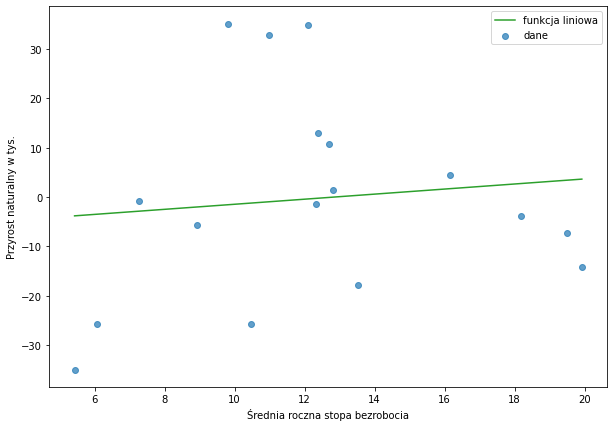

In [89]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_1, os_x), label='funkcja liniowa', color='tab:green')
plt.ylabel("Przyrost naturalny w tys.")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.legend()
plt.show()

# Eksperyment 2

In [90]:
v_pocz_2 = np.random.normal(loc=-30, scale=5, size=2)

x_opt_2, x_historia_2 = optimize.fmin(Q, v_pocz_2,disp=False, retall=True)

Punkt startowy v = [-24.85352168 -33.39100782]
Współczynnik kierunkowy a = 0.5128550381040061
Współczynnik b = -6.596843868937242


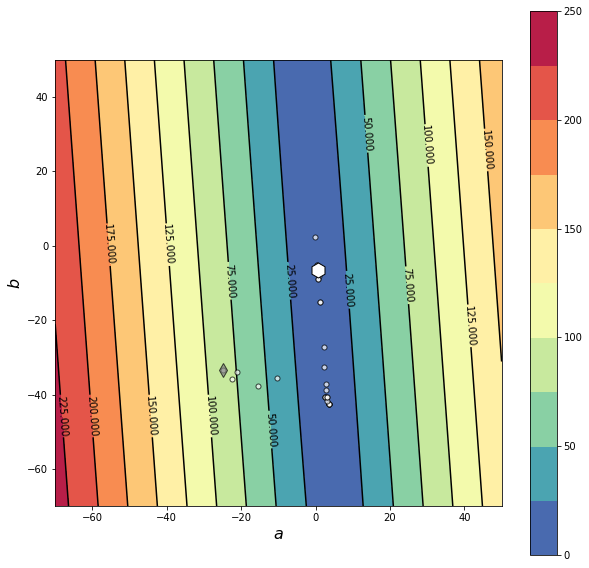

In [91]:
zakres=[-70, 50, -70, 50]
pokaz_2D(Q, x_historia_2, zakres)
print(f'Punkt startowy v = {v_pocz_2}')
print(f'Współczynnik kierunkowy a = {x_opt_2[0]}\nWspółczynnik b = {x_opt_2[1]}')
plt.show()

Wizualizacja znalezionej funkcji liniowej na tle punktów:

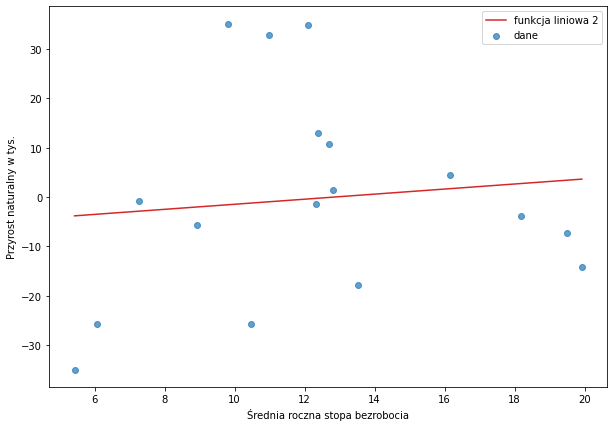

In [92]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_2, os_x), label='funkcja liniowa 2', color='tab:red')
plt.ylabel("Przyrost naturalny w tys.")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.legend()
plt.show()

# Eksperyment 3

In [93]:
v_pocz_3 = np.random.normal(loc=0, scale=75, size=2)

x_opt_3, x_historia_3 = optimize.fmin(Q, v_pocz_3,disp=False, retall=True)

Punkt startowy v = [-146.12376067   92.82763537]
Współczynnik kierunkowy a = 0.5128504495608859
Współczynnik b = -6.596789884969672


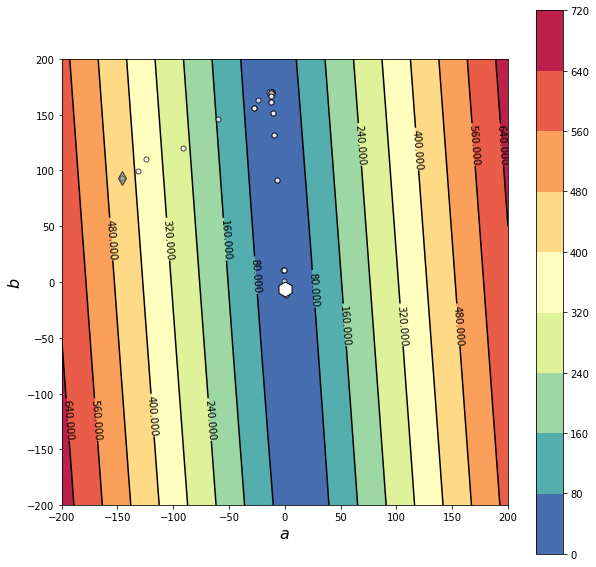

In [94]:
zakres=[-200, 200, -200, 200]
pokaz_2D(Q, x_historia_3, zakres)
print(f'Punkt startowy v = {v_pocz_3}')
print(f'Współczynnik kierunkowy a = {x_opt_3[0]}\nWspółczynnik b = {x_opt_3[1]}')
plt.show()

Wizualizacja znalezionej funkcji liniowej na tle punktów:

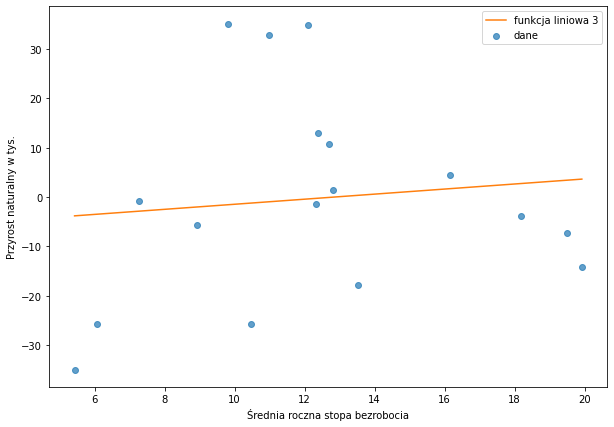

In [95]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_3, os_x), label='funkcja liniowa 3', color='tab:orange')
plt.ylabel("Przyrost naturalny w tys.")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.legend()
plt.show()

# Wnioski

Na jednym wykresie zaprezentuje 3 znalezione proste:

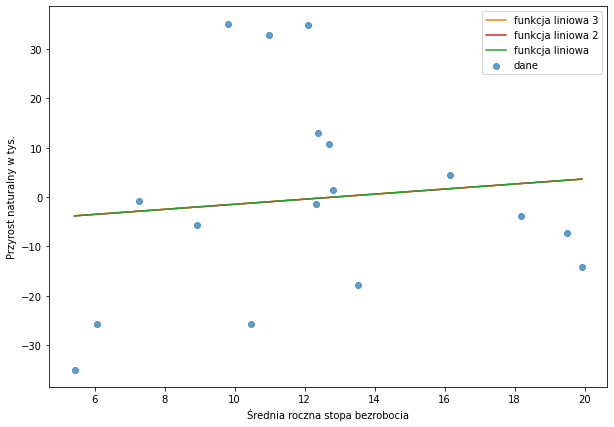

In [96]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, label='dane', alpha=0.7)
os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
plt.plot(os_x, lin(x_opt_3, os_x), label='funkcja liniowa 3', color='tab:orange')
plt.plot(os_x, lin(x_opt_2, os_x), label='funkcja liniowa 2', color='tab:red')
plt.plot(os_x, lin(x_opt_1, os_x), label='funkcja liniowa', color='tab:green')
plt.ylabel("Przyrost naturalny w tys.")
plt.xlabel("Średnia roczna stopa bezrobocia")
plt.legend()
plt.show()

Współczynniki znalezionych funkcji liniowych:

In [97]:
print(f'\nFunkcja liniowa 1:\nWspółczynnik kierunkowy a = {x_opt_1[0]}\nWspółczynnik b = {x_opt_1[1]}')
print(f'\nFunkcja liniowa 2:\nWspółczynnik kierunkowy a = {x_opt_2[0]}\nWspółczynnik b = {x_opt_2[1]}')
print(f'\nFunkcja liniowa 3:\nWspółczynnik kierunkowy a = {x_opt_3[0]}\nWspółczynnik b = {x_opt_3[1]}')


Funkcja liniowa 1:
Współczynnik kierunkowy a = 0.5128529614347652
Współczynnik b = -6.596807140072545

Funkcja liniowa 2:
Współczynnik kierunkowy a = 0.5128550381040061
Współczynnik b = -6.596843868937242

Funkcja liniowa 3:
Współczynnik kierunkowy a = 0.5128504495608859
Współczynnik b = -6.596789884969672


Widać wyraźnie, że niezależnie od początkowych wartości poszukiwań znalezione współczynniki są identyczne, przez co proste na wykresie się pokrywają. Należy jednak zauważyć, że pomiędzy przyrostem naturalnym a średnią roczną stopą bezrobocia nie ma zależności liniowej. Kłócić się można, że im wyższe bezrobocie tym przyrost naturalny jest nieznacznie większy, jednak zwalnianie ludzi z pracy, aby poprawić sytuację demograficzną w kraju nie jest wskazanym rozwiązaniem